In [1]:
import os
import math
from collections import defaultdict
from typing import List 

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sns.set_theme(style='whitegrid', font_scale=1.3, palette='muted', rc={'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')

KB = float(1024)
MB = float(KB ** 2)
GB = float(KB ** 3)
SECUNDS_IN_MINUTE = 60

titlesize = 16

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                   'macro avg_precision', 'training_time', 'eval_time', 'model_size [GB]']

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['model_size [GB]'] = df['model_size']/GB
    df['training_time_in_minutes'] = df['training_time']/SECUNDS_IN_MINUTE
    return df

def visualize_models(df: pd.DataFrame, models: List[str], suptitle: str = ''):   
    df = df[df['model_name'].isin(models)].copy()
    
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    gs = fig.add_gridspec(2, 3)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['name', 'model_name', 'task_name']   
    measures_to_plot = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision']
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
    
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize()
                      for col in measures_to_plot]
        
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0",
                data=df_measures, ax=ax1)
    
    if len(models) < 3:
        y_offset = 0.003
        x_offset = 0.1
        for p in ax1.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_offset
            value = f'{100*p.get_height():.1f}%'
            ax1.text(_x, _y, value, ha="center") 

    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_ylim(bottom=df_measures['value'].min()-0.1)
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    ax1.legend(title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, 0])
    plot_varaible(df, y='training_time_in_minutes', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [min]', title ='Training time', ax=ax2)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 1])
    plot_varaible(df, y='eval_time', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [s]', title = 'Eval time', ax=ax3)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[1, 2])   
    plot_varaible(df, y='model_size [GB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Size [GB]', title = 'Size on drive', ax=ax4)
    
    fig.suptitle(suptitle)
#     fig.tight_layout()   
#     file_name = suptitle.replace(':', '').replace(' ','-') + '.pdf'
#     fig.savefig(file_name, bbox_inches='tight')
     
def plot_varaible(data, x, y, order, title='', remove_xticks=False,
                  xlabel=None, ylabel=None, ax=None):
    ax = sns.barplot(x=x, y=y, order=order, data=data, edgecolor="0", ax=ax)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if remove_xticks:   
        ax.set_xticklabels([])
    ax.set_title(title, fontsize=titlesize)
    
    lim_offset = 0.2
    bar_width = 1

    change_width(ax, bar_width)
    left, right = ax.get_xlim()
    ax.set_xlim(left=left-lim_offset, right=right+lim_offset)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)                     # we change the bar width
        patch.set_x(patch.get_x() + diff * .5)         # we recenter the bar
    
def print_model_comparison(df: pd.DataFrame, original_model: str, distilled_model: str):
    results = defaultdict(dict)
    
    for model in [original_model, distilled_model]:
        for col in df.columns:
            value = df[df['model_name']==model][col].values[0]
            results[model][col] = value
            
    title_1 = "Comparison between:"
    title_2 = f"\n - teacher: {original_model.upper()}\n - student: {distilled_model.upper()}\n"
    seperator = "#"*(int(3*len(title_1)))
    
    text = seperator + "\n" + title_1 + title_2
    
    training_time_gain = results[original_model]['training_time_in_minutes'] / results[distilled_model]['training_time_in_minutes']
    text += f"\nTraining time speedup: {training_time_gain:.1f}x faster"
    
    eval_time_gain = results[original_model]['eval_time'] / results[distilled_model]['eval_time']
    text += f"\nEval time speedup: {eval_time_gain:.1f}x faster"
    
    size_gain = results[original_model]['model_size'] / results[distilled_model]['model_size']
    text += f"\nModel size reduction: {size_gain:.1f}x smaller"
    
    quality_retain = results[distilled_model]['macro avg_f1-score'] / results[original_model]['macro avg_f1-score']
    text += f"\nQuality: {100*quality_retain:.1f}% of teacher's performance"
    text += "\n" + seperator 
    
    fig, ax = plt.subplots()
    ax.set_axis_off()    
    ax.text(0.25, 1, text, bbox={'facecolor':'w','pad': 5}, ha="left", va="top", transform=ax.transAxes, fontsize=16)

# Multiemo EN - All sentences

In [3]:
file_name = 'fasttext_results-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df = load_results_df(file_path)

with pd.option_context('display.max_columns', None):
    display(df)

,name,model_name,task_name,training_time,accuracy,eval_time,z_amb_precision,z_amb_recall,z_amb_f1-score,z_amb_support,z_minus_m_precision,z_minus_m_recall,z_minus_m_f1-score,z_minus_m_support,z_plus_m_precision,z_plus_m_recall,z_plus_m_f1-score,z_plus_m_support,z_zero_precision,z_zero_recall,z_zero_f1-score,z_zero_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,model_size,model_size [GB],training_time_in_minutes
0,multiemo_en_all_sentence-run-1,cc.en.300,multiemo_en_all_sentence,663.122265,0.685814,0.153700,0.530526,0.370044,0.435986,681,0.682353,0.792275,0.733217,2123,0.712938,0.695138,0.703925,1522,0.717638,0.668076,0.691971,1419,0.660864,0.631383,0.641275,5745,0.681174,0.685814,0.680036,5745,2464921443,2.295637,11.052038
1,multiemo_en_all_sentence-run-1,cc.en.300.quant,multiemo_en_all_sentence,1061.217480,0.677807,0.209385,0.604478,0.237885,0.341412,681,0.687605,0.768252,0.725695,2123,0.704636,0.699080,0.701847,1522,0.650157,0.730796,0.688122,1419,0.661719,0.609004,0.614269,5745,0.673014,0.677807,0.664545,5745,341318064,0.317877,17.686958


In [4]:
df[cols_to_display]

,task_name,model_name,accuracy,macro avg_f1-score,macro avg_recall,macro avg_precision,training_time,eval_time,model_size [GB]
0,multiemo_en_all_sentence,cc.en.300,0.685814,0.641275,0.631383,0.660864,663.122265,0.153700,2.295637
1,multiemo_en_all_sentence,cc.en.300.quant,0.677807,0.614269,0.609004,0.661719,1061.217480,0.209385,0.317877


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      2 non-null      object 
 1   model_name                2 non-null      object 
 2   task_name                 2 non-null      object 
 3   training_time             2 non-null      float64
 4   accuracy                  2 non-null      float64
 5   eval_time                 2 non-null      float64
 6   z_amb_precision           2 non-null      float64
 7   z_amb_recall              2 non-null      float64
 8   z_amb_f1-score            2 non-null      float64
 9   z_amb_support             2 non-null      int64  
 10  z_minus_m_precision       2 non-null      float64
 11  z_minus_m_recall          2 non-null      float64
 12  z_minus_m_f1-score        2 non-null      float64
 13  z_minus_m_support         2 non-null      int64  
 14  z_plus_m_preci

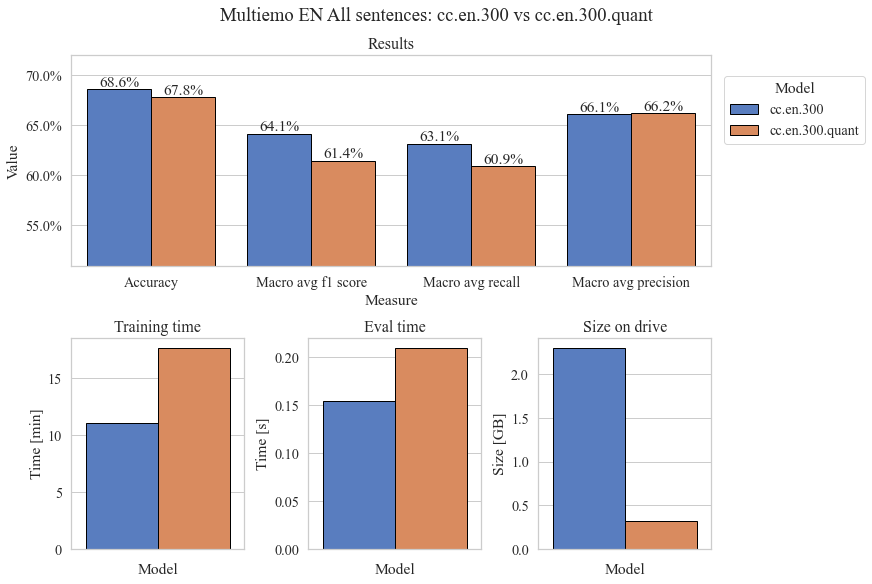

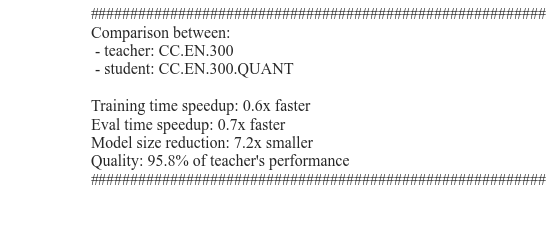

In [6]:
models = ['cc.en.300', 'cc.en.300.quant']
visualize_models(df, models, suptitle='Multiemo EN All sentences: ' + ' vs '.join(models))
print_model_comparison(df, models[0], models[1])

# Multiemo PL - All sentences

In [7]:
file_name = 'fasttext_results-multiemo_pl_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df = load_results_df(file_path)

with pd.option_context('display.max_columns', None):
    display(df)

,name,model_name,task_name,training_time,accuracy,eval_time,z_amb_precision,z_amb_recall,z_amb_f1-score,z_amb_support,z_minus_m_precision,z_minus_m_recall,z_minus_m_f1-score,z_minus_m_support,z_plus_m_precision,z_plus_m_recall,z_plus_m_f1-score,z_plus_m_support,z_zero_precision,z_zero_recall,z_zero_f1-score,z_zero_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,model_size,model_size [GB],training_time_in_minutes
0,multiemo_pl_all_sentence-run-1,kgr10.plain.skipgram.dim300.neg10,multiemo_pl_all_sentence,744.314911,0.684421,0.200016,0.42681,0.406755,0.416541,681,0.717450,0.747527,0.73218,2123,0.719310,0.712221,0.715748,1522,0.714597,0.693446,0.703863,1419,0.644542,0.639987,0.642083,5745,0.682786,0.684421,0.683417,5745,4257331744,3.964949,12.405249
1,multiemo_pl_all_sentence-run-1,kgr10.plain.skipgram.dim300.neg10.quant,multiemo_pl_all_sentence,1312.577801,0.685814,0.238768,0.45283,0.352423,0.396367,681,0.714665,0.759774,0.73653,2123,0.705096,0.727332,0.716041,1522,0.706052,0.690627,0.698254,1419,0.644661,0.632539,0.636798,5745,0.678965,0.685814,0.681326,5745,590954965,0.550370,21.876297


In [8]:
df[cols_to_display]

,task_name,model_name,accuracy,macro avg_f1-score,macro avg_recall,macro avg_precision,training_time,eval_time,model_size [GB]
0,multiemo_pl_all_sentence,kgr10.plain.skipgram.dim300.neg10,0.684421,0.642083,0.639987,0.644542,744.314911,0.200016,3.964949
1,multiemo_pl_all_sentence,kgr10.plain.skipgram.dim300.neg10.quant,0.685814,0.636798,0.632539,0.644661,1312.577801,0.238768,0.550370


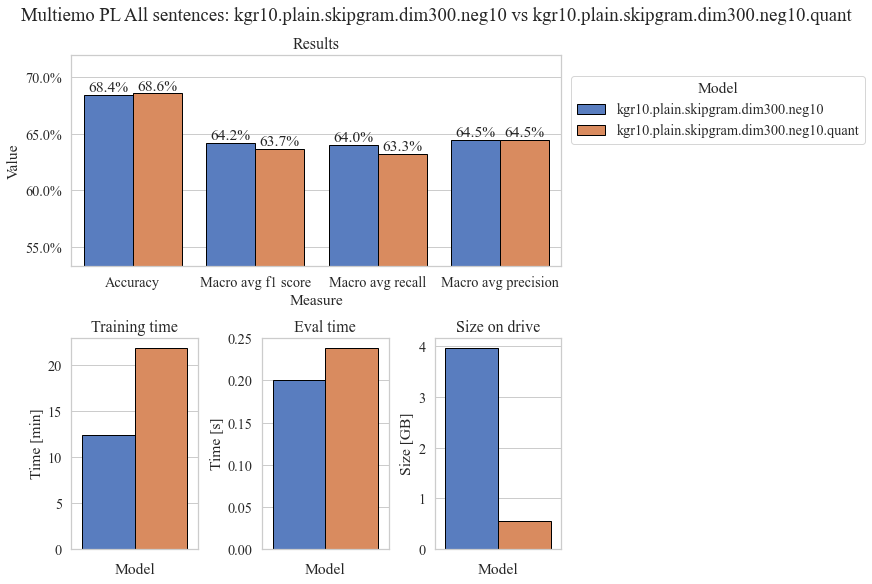

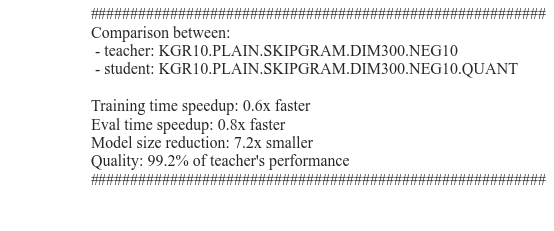

In [9]:
models = ['kgr10.plain.skipgram.dim300.neg10', 'kgr10.plain.skipgram.dim300.neg10.quant']
visualize_models(df, models, suptitle='Multiemo PL All sentences: ' + ' vs '.join(models))
print_model_comparison(df, models[0], models[1])